# Combine spectra of all observations

Multiple exposures of the same object are combined to obtain a better signal-to-noise ratio. The procedure includes the combination of scientific data, data quality map and variance. This notebook includes some visual inspections of sensor defects and how they overlap when combining observations; the data combination procedure; visual inspection of the result; and creation of FITS files with the combined data.

In [31]:
import json
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.io import fits

In [25]:
# Load all science and data quality data on a convenient structure [object][obervation][sci] and [object][obervation][dq], etc
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

raw_data = {}
for object, files in sci_files_object_mapping.items():
    raw_data[object] = {}
    for file in files:
        raw_data[object][file] = {}
        filename = f"redux/cstxeqxbrg{file}"
        hdulist = fits.open(filename)
        raw_data[object][file]["sci"] = hdulist["SCI"].data

        # make a mask for artificial pixels, with no real data
        raw_data[object][file]["artificial_pixels"] = hdulist["SCI"].data == 0

        # mark artificial pixels as dead on DQ and DQ mask
        raw_data[object][file]["dq"] = np.where(
            raw_data[object][file]["artificial_pixels"] == True, 31, hdulist["DQ"].data
        )

        raw_data[object][file]["mask"] = raw_data[object][file]["dq"] == 0
        raw_data[object][file]["var"] = hdulist["VAR"].data
        hdulist.close()

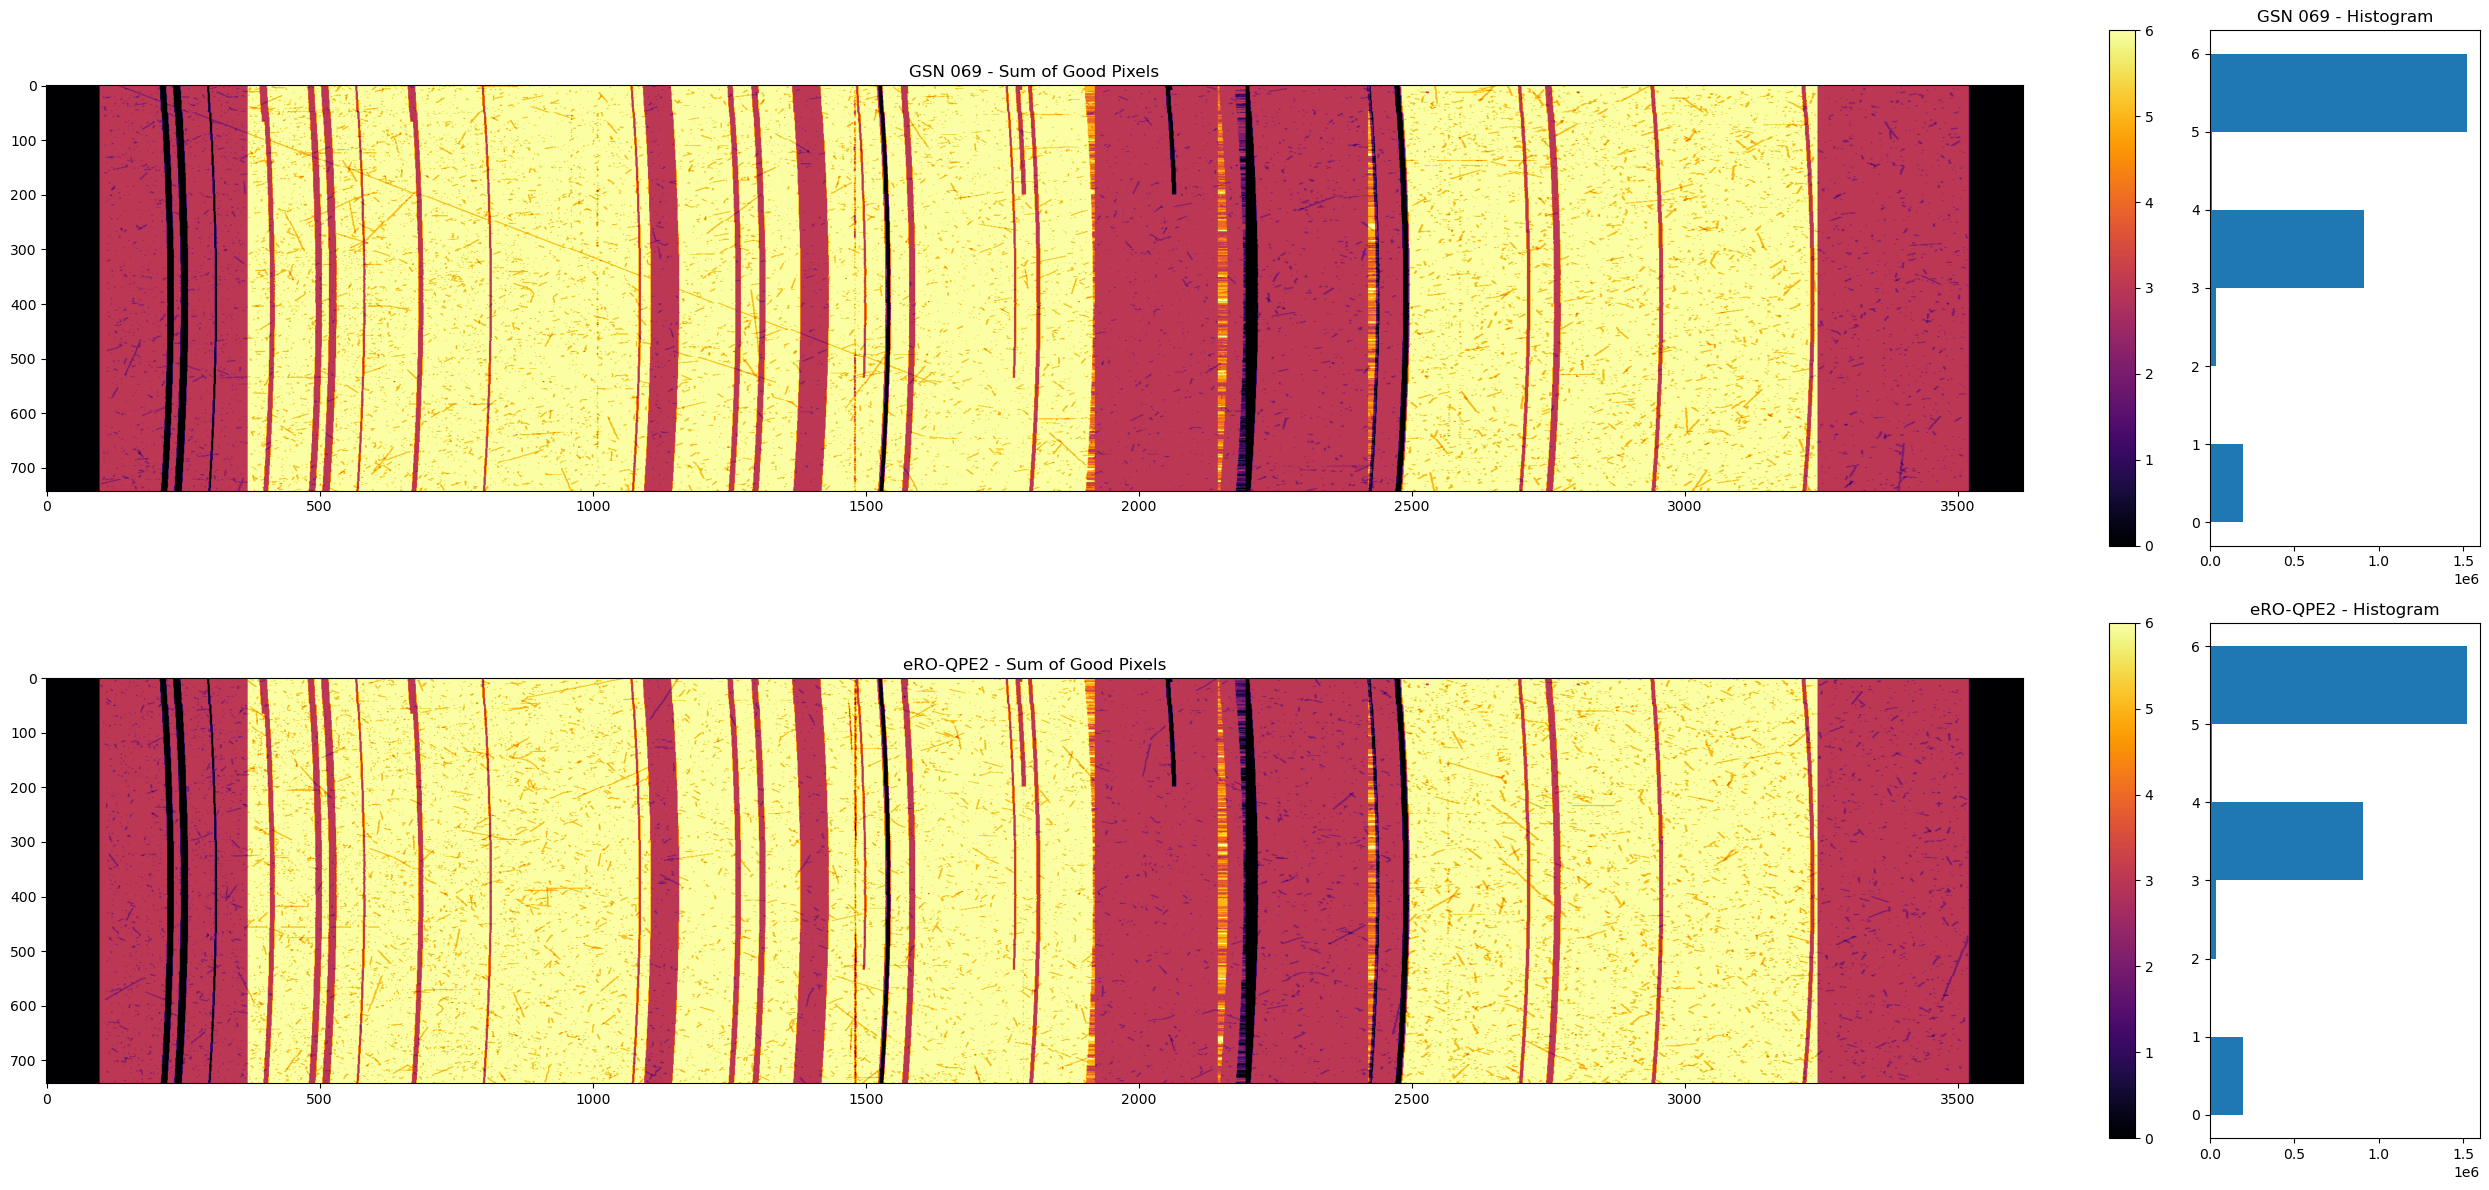

In [27]:
# Data quality assessment. Sums and visualize all data quality masks.
combined_dq = {}
num_objects = len(raw_data.keys())

# Create a GridSpec layout with 2 rows and num_objects*2 columns
fig = plt.figure(figsize=(25, 6 * num_objects))
gs = gridspec.GridSpec(
    num_objects, 2, width_ratios=[8, 1]
)  # 5:1 width ratio between 2D plot and histogram

for idx, object in enumerate(raw_data.keys()):
    combined_dq[object] = [file["mask"] for file in raw_data[object].values()]
    combined_dq[object] = np.sum(combined_dq[object], axis=0)

    # Display the sum of good pixels using most of the row
    ax_imshow = plt.subplot(gs[idx, 0])
    im = ax_imshow.imshow(combined_dq[object], cmap="inferno")
    ax_imshow.set_title(f"{object} - Sum of Good Pixels")
    fig.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)  # Added colorbar here

    # Histogram of good pixels on the right side
    ax_hist = plt.subplot(gs[idx, 1])
    ax_hist.hist(combined_dq[object].ravel(), bins=6, orientation="horizontal")
    ax_hist.set_title(f"{object} - Histogram")

plt.tight_layout()
plt.show()

In [28]:
# Combines sci and var data. Multiply each sci and var observation by its quality mask, then averages all masked observations for each object
combined_spectra = {}
for object, data in raw_data.items():
    combined_spectra[object] = {}

    # Set bad pixels to np.nan
    nan_masked_data = [
        np.where(observation["mask"] == False, np.nan, observation["sci"])
        for observation in data.values()
    ]
    nan_masked_var = [
        np.where(observation["mask"] == False, np.nan, observation["var"])
        for observation in data.values()
    ]

    # Compute the sum, mean, and standard deviation using np.nan-aware functions
    combined_spectra[object]["sum"] = np.nansum(nan_masked_data, axis=0)
    combined_spectra[object]["mean"] = np.nanmean(nan_masked_data, axis=0)
    combined_spectra[object]["std"] = np.nanstd(nan_masked_data, axis=0)
    combined_spectra[object]["sample_size"] = np.sum(
        [data["mask"] for data in data.values()], axis=0
    )
    combined_spectra[object]["DQ"] = raw_data[object][list(data.keys())[0]]["dq"]
    combined_spectra[object]["VAR"] = np.nanmean(nan_masked_var, axis=0)

combined_spectra.keys()

/tmp/ipykernel_406209/3091421328.py:18: RuntimeWarning: Mean of empty slice
  combined_spectra[object]["mean"] = np.nanmean(nan_masked_data, axis=0)
/net/ASTRO/brunoritter/miniconda3/envs/qperedux/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_406209/3091421328.py:24: RuntimeWarning: Mean of empty slice
  combined_spectra[object]["VAR"] = np.nanmean(nan_masked_var, axis=0)


dict_keys(['GSN 069', 'eRO-QPE2'])

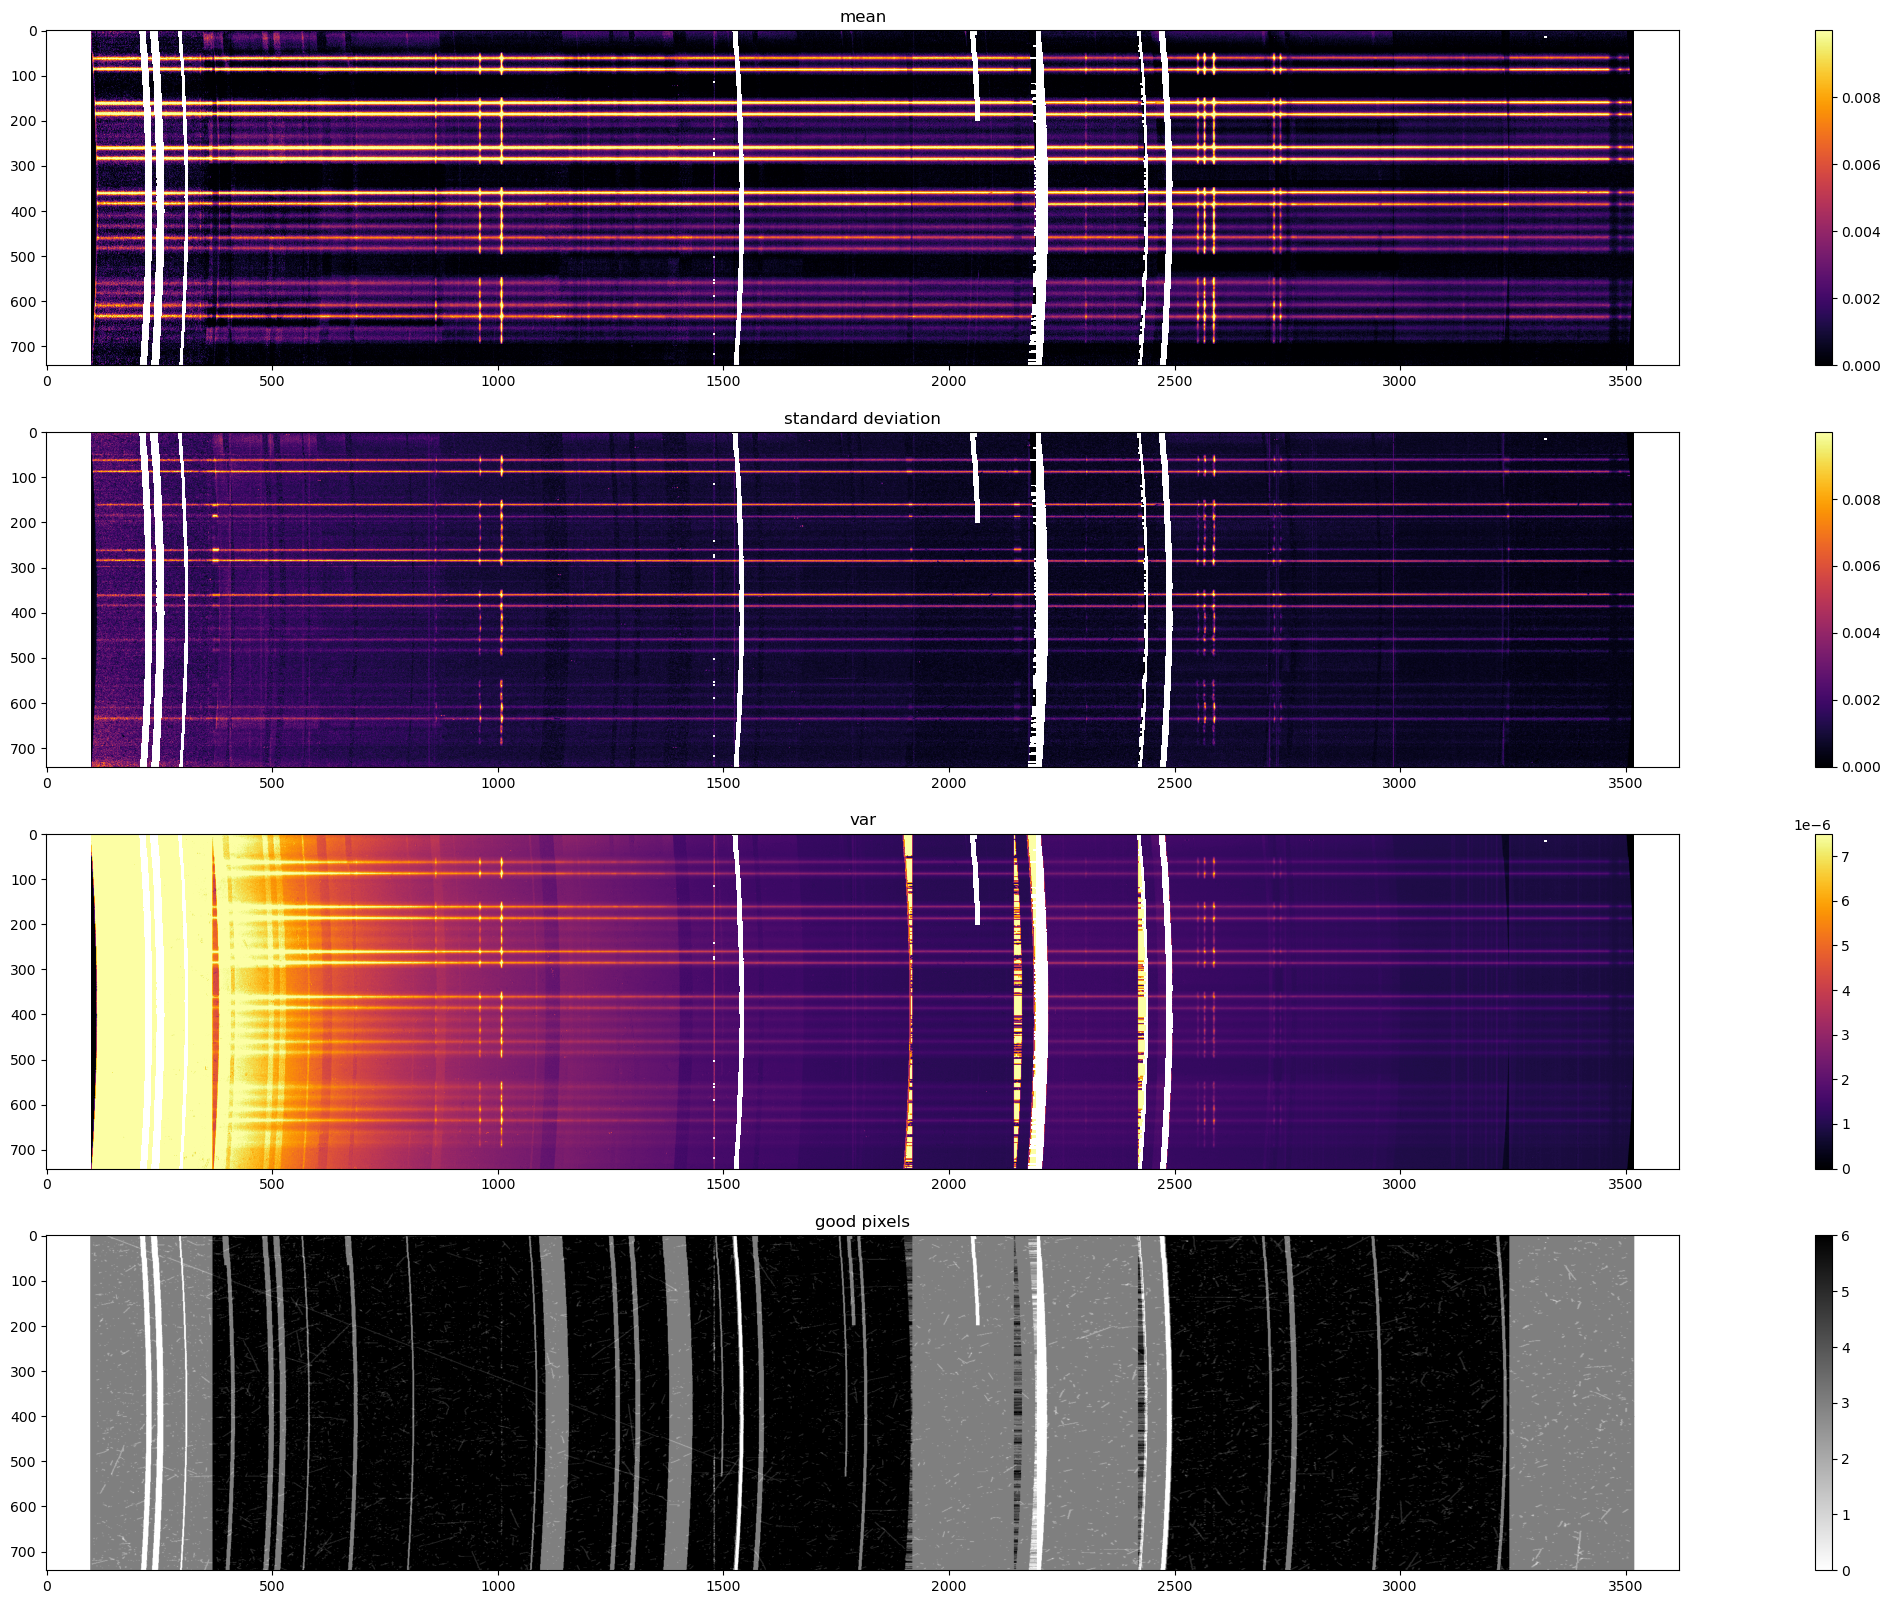

In [29]:
# Visual inspection of the combination of sci data and data quality mask
object = "GSN 069"

# Define thresholds
max_val_mean = 0.01
min_val_mean = 0

max_val_sum = 0.06
min_val_sum = 0

max_val_std = 0.01
min_val_std = 0

min_val_var = 0
max_val_var = 0.0000075

fig, axs = plt.subplots(4, 1, figsize=(35, 20))

im_mean = axs[0].imshow(
    np.clip(combined_spectra[object]["mean"], min_val_mean, max_val_mean),
    cmap="inferno",
)
fig.colorbar(im_mean, ax=axs[0])
axs[0].set_title("mean")

im_std = axs[1].imshow(
    np.clip(combined_spectra[object]["std"], min_val_std, max_val_std), cmap="inferno"
)
fig.colorbar(im_std, ax=axs[1])
axs[1].set_title("standard deviation")

im_var = axs[2].imshow(
    np.clip(combined_spectra[object]["VAR"], min_val_var, max_val_var), cmap="inferno"
)
fig.colorbar(im_var, ax=axs[2])
axs[2].set_title("var")

im_sample = axs[3].imshow(combined_spectra[object]["sample_size"], cmap="binary")
fig.colorbar(im_sample, ax=axs[3])
axs[3].set_title("good pixels")

plt.show()

In [32]:
# Create a new FITS file for the cleaned spectra
atmvars = ["TAMBIENT", "PRESSUR2", "HUMIDITY", "AIRMASS"]
atm_conditions = {atmvar: [] for atmvar in atmvars}
atm_conditions["object_name"] = []

for object_name, observations in sci_files_object_mapping.items():
    for observation in observations:
        with fits.open(f"redux/cstxeqxbrg{observation}") as hdulist:
            primary = hdulist["PRIMARY"]

        for atmvar in atmvars:
            atm_conditions[atmvar].append(primary.header[atmvar])
    obj_name_list = [object_name] * len(observations)
    atm_conditions["object_name"].extend(obj_name_list)

atm_df = pd.DataFrame(atm_conditions)

fits_dic = {}
for object_name in combined_spectra.keys():
    fits_dic[object_name] = {}
    fits_dic[object_name]["SCI"] = combined_spectra[object_name]["mean"]
    fits_dic[object_name]["VAR"] = combined_spectra[object_name]["VAR"]
    fits_dic[object_name]["DQ"] = np.where(
        combined_spectra[object]["sample_size"] >= 3, 0, 31
    ).astype("uint16")


for object_name, data in fits_dic.items():
    filename = f"redux/cstxeqxbrg{sci_files_object_mapping[object_name][0]}"
    with fits.open(filename) as og_hdu:
        # Input the mean of each relevant atmospheric variable in the FITS header
        for atmvar in atmvars:
            og_hdu["PRIMARY"].header[atmvar] = np.mean(
                atm_df[atm_df["object_name"] == object_name][atmvar]
            )

        for key, value in data.items():
            hdu = fits.ImageHDU(data=value, name=key, header=og_hdu[key].header)
            og_hdu[key] = hdu

        # og_hdu["SCI"].header["EXTVER"] = 1
        name = object_name.replace(" ", "").lower()
        filename = f"redux/{name}_combined_spectra.fits"
        og_hdu.writeto(filename, overwrite=True)
        print(f"combined data saved at: {filename}")

combined data saved at: redux/gsn069_combined_spectra.fits
combined data saved at: redux/ero-qpe2_combined_spectra.fits
